In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
import matplotlib.patches as patches
import cv2
import pandas as pd
import sys
import poissonimageediting as poisson
from tqdm.auto import tqdm
from seamless_cloning import *

np.set_printoptions(threshold=sys.maxsize)

/home/leohsu-cs/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image = cv2.imread('./data/target_image/215100.jpg').astype(np.uint8)
dataset_images_dir = "./data/holiday_images"
target_df = pd.read_pickle('data/target_df.pkl')
dataset_df = pd.read_pickle('data/holiday_df.pkl')

In [3]:
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

target_descriptors = np.array(target_df['descriptor'].tolist(), dtype = np.float32)
dataset_descriptors = np.array(dataset_df['descriptor'].tolist(), dtype = np.float32)

matches = matcher.match(target_descriptors, dataset_descriptors)

target_df['match_idx'] = np.array([match.trainIdx for match in matches])

In [4]:
target_df = target_df.sort_values(by = ['size'], ascending = [False])
target_df = target_df[target_df['size'] > 1000]
print(target_df.shape)

(528, 13)


In [5]:
dataset_df.shape


(235547, 12)

In [6]:
# target_df

In [7]:
# u,v = target_df.iloc[0]['coordinate']
# A = target_df.iloc[0]['matrix']
# major_axis_length = target_df.iloc[0]['semi_major_axis']
# minor_axis_length = target_df.iloc[0]['semi_minor_axis']
# angle = target_df.iloc[0]['angle']

# u2,v2 = target_df.iloc[2]['coordinate']
# A2 = target_df.iloc[2]['matrix']
# major_axis_length2 = target_df.iloc[2]['semi_major_axis']
# minor_axis_length2 = target_df.iloc[2]['semi_minor_axis']
# angle2 = target_df.iloc[2]['angle']

In [5]:
def show_img(img):
    print(img.shape)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [9]:
import uuid
import os
import subprocess

def save_temp_image(image_array, prefix='temp'):
    """Save a NumPy array as a temporary image file."""
    temp_filename = f"{prefix}_{uuid.uuid4().hex}.jpg"
    cv2.imwrite(temp_filename, image_array)
    return temp_filename

def read_temp_image(filename):
    """Read an image file into a NumPy array."""
    image_array = cv2.imread(filename)
    return image_array

def delete_temp_file(filename):
    """Delete a temporary file."""
    os.remove(filename)

def blend_images_with_fpie(source_array, target_array, height0, width0, height1, width1, iterations, gradient_method):
    # Save source and target images as temporary files
    source_path = save_temp_image(source_array, prefix='source')
    target_path = save_temp_image(target_array, prefix='target')
    output_path = f"result_{uuid.uuid4().hex}.jpg"

    back_end_choice = "cuda"

    # Construct the fpie command
    fpie_command = [
        'fpie',
        '-b', back_end_choice,
        '-s', source_path,
        '-t', target_path,
        '-o', output_path,
        '-h0', str(height0), 
        '-w0', str(width0),
        '-h1', str(height1),
        '-w1', str(width1),
        '-n', str(iterations),
        '-g', gradient_method
    ]

    # Run the fpie command
    subprocess.run(fpie_command, check=True)

    # Read the resulting image into a NumPy array
    result_array = read_temp_image(output_path)

    # Clean up temporary files
    delete_temp_file(source_path)
    delete_temp_file(target_path)
    delete_temp_file(output_path)

    return result_array

In [6]:
default_dir = '/home/leohsu-cs/fast-poisson-image-editing/data/test1'
solver = 'spsolve'
scale = 1.0

cloner = PoissonSeamlessCloner(default_dir, solver, scale)

gradient_mixing_mode_list = ["max", "alpha"]
gradient_mixing_mode = gradient_mixing_mode_list[0]

gradient_mixing_alpha = 1.0

In [8]:
def warp_and_paste_ellipse(source_image_path, destination_image, source_params, destination_params):
    source_image = cv2.imread(source_image_path).astype(np.uint8)

    u, v, major_axis_length, minor_axis_length, angle = source_params
    u2, v2, major_axis_length2, minor_axis_length2, angle2 = destination_params

    # Define the source ellipse parameters
    center1 = (int(u), int(v))
    axes1 = (int(major_axis_length), int(minor_axis_length))
    angle1 = np.degrees(angle)
    height1, width1 = center1
    print(height1, width1)

    # Define the destination ellipse parameters
    center2 = (int(u2), int(v2))
    axes2 = (int(major_axis_length2), int(minor_axis_length2))
    angle2 = np.degrees(angle2)

    # Create a mask for the source ellipse
    mask = np.zeros_like(source_image)
    cv2.ellipse(mask, center1, axes1, angle1, 0, 360, (255, 255, 255), -1)

    # Extract the source ellipse region
    source_ellipse_region = cv2.bitwise_and(source_image, mask)

    # Define the bounding box around the source ellipse
    src_rect = cv2.boxPoints(((center1[0], center1[1]), (axes1[0] * 2, axes1[1] * 2), angle1))
    src_rect = np.int0(src_rect)

    # Define the bounding box around the destination ellipse
    dst_rect = cv2.boxPoints(((center2[0], center2[1]), (axes2[0] * 2, axes2[1] * 2), angle2))
    dst_rect = np.int0(dst_rect)
    height2, width2 = center2

    # Compute the perspective transformation matrix
    M = cv2.getPerspectiveTransform(np.float32(src_rect), np.float32(dst_rect))

    # warp
    warped_ellipse_region = cv2.warpPerspective(source_ellipse_region, M, (destination_image.shape[1], destination_image.shape[0]))

    # Create a mask for the destination ellipse to combine the images correctly
    mask2 = np.zeros_like(destination_image)
    cv2.ellipse(mask2, center2, axes2, angle2, 0, 360, (255, 255, 255), -1)

    warped_ellipse_only = cv2.bitwise_and(warped_ellipse_region, mask2)

    # result = cv2.add(cv2.bitwise_and(destination_image, cv2.bitwise_not(mask2)), warped_ellipse_only)

    # result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    # Poisson blending
    mask_ = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)
    print(mask_.shape)
    print(warped_ellipse_only.shape)
    print(destination_image.shape)

    result_rgb = cloner.poisson_blend_rgb_with_input(warped_ellipse_only, destination_image, mask_, gradient_mixing_mode, gradient_mixing_alpha)
    print(result_rgb.shape)
    return result_rgb

In [9]:
canvas = np.zeros_like(image)
for index, row in tqdm(target_df.iterrows(), total=target_df.shape[0]):
    target_u, target_v = row['coordinate']
    target_A = row['matrix']
    target_major_axis_length = row['semi_major_axis']
    target_minor_axis_length = row['semi_minor_axis']
    target_angle = row['angle']
    
    match_idx = row['match_idx']
    match_image_name  = dataset_df.loc[match_idx, 'image_name']
    match_u, match_v = dataset_df.loc[match_idx, 'coordinate']
    match_A = np.array(dataset_df.loc[match_idx, 'matrix'])
    match_major_axis_length = dataset_df.loc[match_idx, 'semi_major_axis']
    match_minor_axis_length = dataset_df.loc[match_idx, 'semi_minor_axis']
    match_angle = dataset_df.loc[match_idx, 'angle']
    
    match_image_path = f"{dataset_images_dir}/{match_image_name}"

    
    source_params = (match_u, match_v, match_major_axis_length, match_minor_axis_length, match_angle)
    destination_params = (target_u, target_v, target_major_axis_length, target_minor_axis_length, target_angle)

    canvas = warp_and_paste_ellipse(match_image_path, canvas, source_params, destination_params)
    
    print(canvas.max(), canvas.min())
    
    # show_img(canvas)

  0%|          | 0/528 [00:00<?, ?it/s]/tmp/ipykernel_1340991/2366947352.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  src_rect = np.int0(src_rect)
/tmp/ipykernel_1340991/2366947352.py:32: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  dst_rect = np.int0(dst_rect)


1905 1756
(1920, 2560)
(1920, 2560, 3)
(1920, 2560, 3)


  0%|          | 1/528 [00:33<4:52:17, 33.28s/it]

(1920, 2560, 3)
1.0 0.0
451 1506


error: OpenCV(4.6.0) /croot/opencv-suite_1691620365762/work/modules/core/src/arithm.cpp:212: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


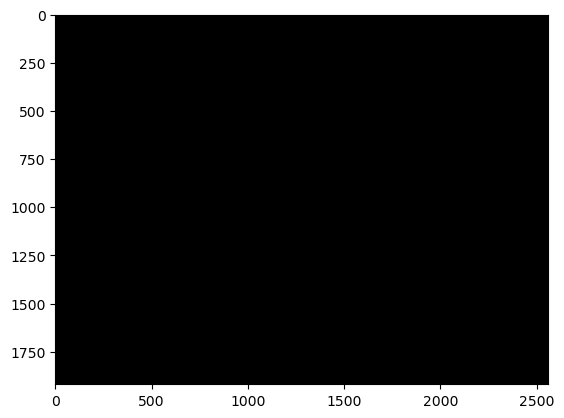

In [ ]:
plt.imshow(canvas)